In [1]:
%matplotlib inline

import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeQuitoV2
from qiskit.visualization import plot_gate_map
from scipy.optimize import minimize
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
from scipy.linalg import eigh
from scipy.linalg import fractional_matrix_power

In [2]:
def get_backend_info(backend):
    if isinstance(backend, GenericBackendV2):
        num_qubits = backend.num_qubits
        coupling_map = backend.coupling_map
    else:
        num_qubits = backend.configuration().num_qubits
        coupling_map = CouplingMap(backend.configuration().coupling_map)
    
    return num_qubits, coupling_map

def get_unique_bonds(coupling_map):
    bond_set = set()
    for i, j in coupling_map:
        bond = tuple(sorted([i, j]))
        bond_set.add(bond)
    return list(bond_set)

In [3]:
def build_hva_layers(params, backend, num_layers=1):
    assert len(params) == 3 * num_layers, "Parameteranzahl stimmt nicht mit Anzahl der Layer überein!"
    
    num_qubits, coupling_map = get_backend_info(backend)
    bonds = get_unique_bonds(coupling_map)
    qc = QuantumCircuit(num_qubits)

    # Initialzustand: |+>^N durch H auf allen Qubits
    qc.h(range(num_qubits))

    # Schleife über die Layer
    for layer in range(num_layers):
        alpha = params[3 * layer]
        beta = params[3 * layer + 1]
        gamma = params[3 * layer + 2]

        # ZZ-Terme (nur für gekoppelte Qubits)
        for i, j in bonds:
            qc.cx(i, j)
            qc.rz(alpha, j)
            qc.cx(i, j)

        # Z-Feld (longitudinal)
        for i in range(num_qubits):
            qc.rz(beta, i)

        # X-Feld (transversal)
        for i in range(num_qubits):
            qc.rx(gamma, i)

    return qc


def build_sparse_hamiltonian(hx, hz, backend, J=-1, return_paulis=False):
    num_qubits, coupling_map = get_backend_info(backend)
    bonds = get_unique_bonds(coupling_map)
    paulis = []
    coeffs = []

    # ZZ-Terme
    for i, j in bonds:
        z_str = ['I'] * num_qubits
        z_str[i] = 'Z'
        z_str[j] = 'Z'
        pauli = ''.join(reversed(z_str))
        paulis.append(pauli)
        coeffs.append(J)

    # X- und Z-Feld-Terme
    for i in range(num_qubits):
        x_str = ['I'] * num_qubits
        x_str[i] = 'X'
        pauli_x = ''.join(reversed(x_str))
        paulis.append(pauli_x)
        coeffs.append(hx)

        z_str = ['I'] * num_qubits
        z_str[i] = 'Z'
        pauli_z = ''.join(reversed(z_str))
        paulis.append(pauli_z)
        coeffs.append(hz)

    hamiltonian = SparsePauliOp.from_list(list(zip(paulis, coeffs)))

    if return_paulis:
        return hamiltonian, paulis
    else:
        return hamiltonian

In [4]:
def compute_energy(params, H_sparse, backend,num_layers=1):
    qc = build_hva_layers(params, backend,num_layers)
    psi = Statevector.from_instruction(qc)
    return np.real(psi.expectation_value(H_sparse))


def compute_exact_ground_energy(H_sparse):
    # Konvertiere SparsePauliOp in vollständige Matrix
    H_dense = H_sparse.to_matrix()
    eigvals = eigh(H_dense, eigvals_only=True)
    return np.min(eigvals)

def compute_error(params, H_sparse, backend, energy_exact,num_layers=1):
    energy_approx = compute_energy(params, H_sparse, backend,num_layers)
    return abs(energy_approx-energy_exact)/abs(energy_exact)

def optimize_energy(initial_params, H_sparse, backend, energy_exact,num_layers=1):
    result = minimize(
        compute_error,
        initial_params,
        args=(H_sparse, backend, energy_exact,num_layers),
        method='COBYLA',
        options={'maxiter': 200}
    )
    return result.x, result.fun

In [5]:
def find_best_initial_params(H_sparse, backend, scan_points=5, angle_range=(-np.pi, np.pi),num_layers=1):
    best_error = np.inf
    best_params = None
    
    energy_exact = compute_exact_ground_energy(H_sparse)
    
    alpha_vals = np.linspace(*angle_range, scan_points)
    beta_vals = np.linspace(*angle_range, scan_points)
    gamma_vals = np.linspace(*angle_range, scan_points)


    param_grid = product(alpha_vals, beta_vals, gamma_vals, repeat=num_layers)
    for param_tuple in param_grid:
        params = list(param_tuple)
        error = compute_error(params, H_sparse, backend, energy_exact, num_layers=num_layers)
        if error < best_error:
            best_error = error
            best_params = params

    return np.array(best_params), energy_exact


def run_hva_grid_scan(
    backend,
    hx_range=np.linspace(-2, 2, 20),
    hz_range=np.linspace(-2, 2, 20),
    plot_2d=True,
    plot_3d=False,
    J = -1,
    num_layers=1
):
    
    hx_vals = hx_range
    hz_vals = hz_range
    error_grid = np.zeros((len(hx_vals), len(hz_vals)))
    param_grid = np.zeros((len(hx_vals), len(hz_vals), 3))

    for (i, hx), (j, hz) in tqdm(product(enumerate(hx_vals), enumerate(hz_vals)),
                                 total=len(hx_vals)*len(hz_vals), desc="HVA Grid Scan"):
        # 1. Hamiltonian erstellen
        H_sparse = build_sparse_hamiltonian(hx, hz, backend, J = J)

        # 2. Initialparameter bestimmen
        best_guess, energy_exact = find_best_initial_params(H_sparse=H_sparse, backend=backend, num_layers=num_layers)
        opt_params, opt_error = optimize_energy(best_guess, H_sparse, backend, energy_exact, num_layers=num_layers)


        # 4. Ergebnisse speichern
        error_grid[i, j] = opt_error
        param_grid[i, j, :] = opt_params

    # Mesh erstellen für Plot
    hx_mesh, hz_mesh = np.meshgrid(hz_vals, hx_vals)

    if plot_2d:
        plt.figure(figsize=(8, 6))
        cp = plt.contourf(hz_mesh, hx_mesh, error_grid, levels=50, cmap='viridis')
        plt.colorbar(cp, label=r'Fehler $|E_{\mathrm{var}} - E_{\mathrm{exact}}|$')
        plt.xlabel(r'$h_z$')
        plt.ylabel(r'$h_x$')
        plt.title('HVA-Fehler bei 1 Layer in Abhängigkeit von $h_x$ und $h_z$ mit J = -1')
        plt.show()

    if plot_3d:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(hx_mesh, hz_mesh, error_grid,
                               cmap='viridis', edgecolor='k', linewidth=0.3, antialiased=True)
        ax.set_xlabel(r'$h_x$')
        ax.set_ylabel(r'$h_z$')
        ax.set_zlabel(r'Fehler $|E_{\mathrm{var}} - E_{\mathrm{exact}}|$')
        ax.set_title('HVA Fehleroberfläche bei 1 Layer')
        fig.colorbar(surf, shrink=0.5, aspect=10, label='Fehler')
        plt.show()


    return error_grid, param_grid

Initial Error: 0.09876894214132027
Exakte Energie:  -9.986340263709902
Optimierte Parameter: [-1.39687110e-05 -1.95342561e+00  1.57087629e+00]
Minimaler Fehler: 0.00387513127835354


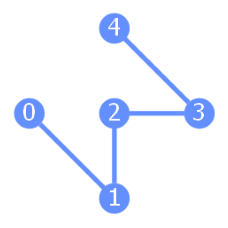

In [7]:
## Test

backend = FakeAthensV2()
num_qubits, coupling_map = get_backend_info(backend)
plot_gate_map(backend)

hx = 1
hz = 1
H_sparse = build_sparse_hamiltonian(hx, hz, backend, J=-1)

best_guess, energy_exact = find_best_initial_params(H_sparse, backend)

opt_params, min_error = optimize_energy(best_guess, H_sparse, backend, energy_exact)

print(f"Initial Error: {compute_error(best_guess, H_sparse, backend, energy_exact, num_layers=1)}")
print("Exakte Energie: ", energy_exact)
print("Optimierte Parameter:", opt_params)
print("Minimaler Fehler:", min_error)


In [ ]:
error_grid, param_grid = run_hva_grid_scan(backend=backend)

In [ ]:
backend = FakeAthensV2()
num_qubits, coupling_map = get_backend_info(backend)
plot_gate_map(backend)

hx = 1
hz = 0.1
H_sparse = build_sparse_hamiltonian(hx, hz, backend, J=-1)

print("Fehler vor Optimierung:", compute_error(best_guess, H_sparse, backend, energy_exact, num_layers=1))
opt_params, opt_error = optimize_energy(best_guess, H_sparse, backend, energy_exact, num_layers=1)
print("Fehler nach Optimierung:", opt_error)

In [ ]:
H_sparse = build_sparse_hamiltonian(1, 1, backend, J=-1)
best_guess, energy_exact = find_best_initial_params(H_sparse, backend, num_layers=1)
opt_params, min_error = optimize_energy(best_guess, H_sparse, backend, energy_exact, num_layers=1)
print(min_error)


In [ ]:
# Maximalen Fehlerwert berechnen
max_error = np.max(error_grid)

# Index (Zeile, Spalte) des Maximalwerts finden
max_index = np.unravel_index(np.argmax(error_grid), error_grid.shape)

print("Maximaler Fehlerwert:", max_error)
print("Index im Grid (row, col):", max_index)

# Optional: die zugehörigen h_x und h_z Werte
hx_vals=np.linspace(-2, 2, 20)
hz_vals=np.linspace(-2, 2, 20)
hx_mesh, hz_mesh = np.meshgrid(hz_vals, hx_vals)
hx_max = hx_vals[max_index[0]]
hz_max = hz_vals[max_index[1]]

print("Zugehörige Werte: h_x =", hx_max, ", h_z =", hz_max)

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(hx_mesh, hz_mesh, error_grid,
                       cmap='viridis', edgecolor='k', linewidth=0.3, antialiased=True)

ax.set_xlabel('$h_x$')
ax.set_ylabel('$h_z$')
ax.set_zlabel('Relativer Fehler')
ax.set_title('HVA Fehleroberfläche bei 1 Layer')
fig.colorbar(surf, shrink=0.5, aspect=10, label='Fehler')

plt.show()

In [ ]:
# Lineare Kopplung: 0–1–2–3
coupling = CouplingMap(couplinglist=[(0, 1), (1, 2), (2, 3)])
backend = GenericBackendV2(num_qubits=4, coupling_map=coupling)

num_qubits, coupling_map = get_backend_info(backend)
plot_gate_map(backend)

hx = 1
hz = 1
H_sparse = build_sparse_hamiltonian(hx, hz, backend, J=-1)

best_guess, energy_exact = find_best_initial_params(H_sparse, backend)

opt_params, min_error = optimize_energy(best_guess, H_sparse, backend, energy_exact)

print(f"Initial Error        : {compute_error(best_guess, H_sparse, backend, energy_exact, num_layers=1)}")
print("Exakte Energie       : ", energy_exact)
print("Startparameter       :",best_guess)
print("Optimierte Parameter :", opt_params)
print("Minimaler Fehler     :", min_error)

In [ ]:
# Kreis Kopplung: 0–1–2–3-4-0
coupling = CouplingMap(couplinglist=[(0, 1), (1, 2), (2, 3), (3,4), (4,0)])
backend = GenericBackendV2(num_qubits=5, coupling_map=coupling)
plot_gate_map(backend)
error_grid, param_grid = run_hva_grid_scan(backend=backend)

In [ ]:
# Maximalen Fehlerwert berechnen
max_error = np.max(error_grid)

# Index (Zeile, Spalte) des Maximalwerts finden
max_index = np.unravel_index(np.argmax(error_grid), error_grid.shape)

print("Maximaler Fehlerwert:", max_error)
print("Index im Grid (row, col):", max_index)

# Optional: die zugehörigen h_x und h_z Werte
hx_vals=np.linspace(-2, 2, 20)
hz_vals=np.linspace(-2, 2, 20)
hx_mesh, hz_mesh = np.meshgrid(hz_vals, hx_vals)
hx_max = hx_vals[max_index[0]]
hz_max = hz_vals[max_index[1]]

print("Zugehörige Werte: h_x =", hx_max, ", h_z =", hz_max)

In [ ]:
#FakeQuito J=-1
backend = FakeQuitoV2()
plot_gate_map(backend)
error_grid, param_grid = run_hva_grid_scan(backend=backend)

In [ ]:
min_error = np.min(error_grid)

# Index (Zeile, Spalte) des Maximalwerts finden
min_index = np.unravel_index(np.argmin(error_grid), error_grid.shape)


print(f"Minimaler Fehlerwert: {min_error*100} %")
print("Optimale Parameter [ZZ,Z,X]:", param_grid[min_index[0],min_index[1],:])

In [ ]:
#FakeQuito J=1
backend = FakeQuitoV2()
plot_gate_map(backend)
error_grid, param_grid = run_hva_grid_scan(backend=backend,J=1)

In [ ]:
min_error = np.min(error_grid)

# Index (Zeile, Spalte) des Maximalwerts finden
min_index = np.unravel_index(np.argmin(error_grid), error_grid.shape)


print(f"Minimaler Fehlerwert: {min_error*100} %")
print("Optimale Parameter [ZZ,Z,X]:", param_grid[min_index[0],min_index[1],:])

max_error = np.max(error_grid)

# Index (Zeile, Spalte) des Maximalwerts finden
max_index = np.unravel_index(np.argmax(error_grid), error_grid.shape)

print(f"Maximaler Fehlerwert: {max_error*100} %")
print("Optimale Parameter [ZZ,Z,X]:", param_grid[max_index[0],max_index[1],:])

## VQE auf Circuits

In [ ]:
import networkx as nx
from qiskit.quantum_info import Pauli

def commute(pauli1, pauli2):
    """Prüft ob zwei Pauli-Strings kommutieren."""
    p1 = Pauli(pauli1)
    p2 = Pauli(pauli2)
    return p1.commutes(p2)

def locally_commutable(p1, p2):
    """
    Prüft ob zwei Pauli-Strings lokal messbar sind: 
    auf keinem Qubit gibt es gleichzeitig z.B. X und Y.
    """
    for a, b in zip(p1, p2):
        if a == 'I' or b == 'I':
            continue
        if a != b:
            return False  # unterschiedliche Nicht-I-Terms → nicht lokal gleichzeitig messbar
    return True

def group_paulis(pauli_strings):
    """
    Gruppiert Pauli-Strings in Gruppen mit gemeinsamer Messbasis (lokal messbar).
    """
    G = nx.Graph()
    G.add_nodes_from(range(len(pauli_strings)))

    # Kante falls sie NICHT gemeinsam messbar sind (Konfliktgraph)
    for i in range(len(pauli_strings)):
        for j in range(i + 1, len(pauli_strings)):
            if not locally_commutable(pauli_strings[i], pauli_strings[j]):
                G.add_edge(i, j)

    # Graph Coloring
    coloring = nx.coloring.greedy_color(G, strategy="largest_first")

    # Gruppieren nach Farben
    groups = {}
    for idx, color in coloring.items():
        groups.setdefault(color, []).append(pauli_strings[idx])

    return list(groups.values())


def determine_measurement_basis(pauli_group):
    """
    Bestimmt eine Messbasis (als Liste von 'X', 'Y', 'Z', 'I') für eine Gruppe kommutierender Pauli-Strings.
    Die zurückgegebene Basis diagonalisiert alle Paulis in der Gruppe gleichzeitig.
    """
    num_qubits = len(pauli_group[0])
    basis = ['Z'] * num_qubits  # Default: Messung in Z

    for qubit in range(num_qubits):
        paulis_on_qubit = set(p[qubit] for p in pauli_group if p[qubit] != 'I')

        if not paulis_on_qubit:
            basis[qubit] = 'I'
        elif paulis_on_qubit == {'Z'}:
            basis[qubit] = 'Z'
        elif paulis_on_qubit == {'X'}:
            basis[qubit] = 'X'
        elif paulis_on_qubit == {'Y'}:
            basis[qubit] = 'Y'
        else:
            # Mehrere unterschiedliche Paulis (X,Y,Z) → nicht gemeinsam diagonal.
            # In Gruppenbildung sollte das nicht vorkommen.
            raise ValueError(f"Nicht kompatible Paulis auf Qubit {qubit}: {paulis_on_qubit}")

    return basis

def apply_measurement_bases(base_circuit, measurement_bases):
    """
    Für jede Messbasis wird eine Kopie des Circuits erstellt, 
    mit Umwandlung der Messbasis vor der Messung.
    
    Args:
        base_circuit: QuantumCircuit ohne Messung.
        measurement_bases: Liste von Listen, z.B. [['X', 'Z', 'I'], ['Y', 'Z', 'I']]
    
    Returns:
        List[QuantumCircuit]: jeweils mit Messungen in der gegebenen Basis.
    """
    circuits=[]

    for basis in measurement_bases:
        qc = base_circuit.copy()

        for qubit, b in enumerate(basis):
            if b == 'X':
                qc.h(qubit)
            elif b == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
            elif b == 'Z':
                pass  # keine Änderung
            elif b == 'I':
                pass  # keine Änderung oder optional Messung weglassen
            else:
                raise ValueError(f"Ungültige Messbasis: {b} für Qubit {qubit}")

        qc.measure_all()
        circuits.append(qc)

    return circuits

def get_expectation(pauli, counts):
        estimator = 0
        pz = list(reversed([{Pauli("I"):'0'}.get(p,'1') for p in pauli]))
        #compute estimator
        for key in counts.keys():
            k = [i for i in key]            
            #compute the overlap in the computational basis
            sgn = sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pz, k)])
            #update estimator
            estimator += (-1)**sgn*counts[key]

        return estimator/sum(counts.values())

def get_pauli_expectation_dict(groups, counts):
    pauli_expectations = []

    for idx, group in enumerate(groups):
        group_expectation = {}
        for pauli_str in group:
            pauli = Pauli(pauli_str)
            exp_val = get_expectation(pauli=pauli, counts=counts[idx])
            group_expectation[pauli_str] = exp_val
        pauli_expectations.append(group_expectation)
        
    return pauli_expectations

def get_energy(H, pauli_expectations):
    paulis = [str(p) for p in H.paulis]
    coeffs = H.coeffs

    energy = 0
    for pauli, coeff in zip(paulis, coeffs):
        # Suche Erwartungswert in deiner Liste der Gruppen
        found = False
        for group_expectation in pauli_expectations:
            if pauli in group_expectation:
                energy += coeff * group_expectation[pauli]
                found = True
                break
        if not found:
            raise ValueError(f"Erwartungswert für {pauli} nicht gefunden!")
        
    return energy

def vqe_cost(params,
             backend, 
             simulator,
             num_layers,
             meas_bases,
             groups,
             Hamiltonian,
             exact_energy):
    
    circuit = build_hva_layers(params, backend, num_layers=num_layers)
    circuits = apply_measurement_bases(circuit, meas_bases)
    transpiled = transpile(circuits, backend=backend, optimization_level=3)
    
    counts = []
    for circ in transpiled:
        result = simulator.run(circ, shots=16*1024).result()
        counts.append(result.get_counts())
    
    # Erwartungswerte berechnen
    pauli_expectations = get_pauli_expectation_dict(groups, counts)
    energy = get_energy(Hamiltonian, pauli_expectations)
    rel_error = abs(exact_energy - energy) / abs(exact_energy)
    return rel_error


In [ ]:
#FakeQuito J=-1
backend = FakeQuitoV2()
plot_gate_map(backend)
error_grid, param_grid = run_hva_grid_scan(backend=backend)

min_error = np.min(error_grid)

# Index (Zeile, Spalte) des Maximalwerts finden
min_index = np.unravel_index(np.argmin(error_grid), error_grid.shape)
opt_params = param_grid[min_index[0],min_index[1],:]

hx_vals=np.linspace(-2, 2, 20)
hz_vals=np.linspace(-2, 2, 20)
hx_mesh, hz_mesh = np.meshgrid(hz_vals, hx_vals)
hx_min = hx_vals[min_index[0]]
hz_min = hz_vals[min_index[1]]

print("Zugehörige Werte: h_x =", hx_min, ", h_z =", hz_min)
print(f"Minimaler Fehlerwert: {min_error*100} %")
print("Optimale Parameter [ZZ,Z,X]:", opt_params)

In [ ]:
hx_min = 0.10526315789473673
hz_min = 2.0
opt_params = [-6.29010556e-05, -1.60006899e+00,  1.57076956e+00]

H, pauli_strings = build_sparse_hamiltonian(hx = hx_min, hz= hz_min, backend=backend, J=-1, return_paulis=True)
groups = group_paulis(pauli_strings)
measurement_bases = []

for i, group in enumerate(groups):
    print(f"Gruppe {i+1}: {group}")
    basis = determine_measurement_basis(group)
    print(f"Messbasis {i+1}: {basis}")
    measurement_bases.append(basis)

circuit = build_hva_layers(opt_params, backend)
circuits = apply_measurement_bases(circuit, measurement_bases)

"""for idx, qc in enumerate(circuits):
    print(f"Circuit für Basis {idx}:")
    print(qc)"""

counts = []
#simulator = AerSimulator()
simulator = AerSimulator.from_backend(backend)
transpiled_circuits = transpile(circuits, backend=backend, optimization_level=3)
for circuit in transpiled_circuits:
    result = simulator.run(circuit,shots=1024).result()
    counts.append(result.get_counts())
    
pauli_expectations = get_pauli_expectation_dict(groups, counts)


energy = get_energy(H, pauli_expectations)
    
exact_energy = compute_exact_ground_energy(H)
rel_error = abs(exact_energy - energy) / abs(exact_energy)
print(f"Relativer Fehler: {rel_error*100} %")

# Optimierung mit COBYLA oder Nelder-Mead (robust bei Noisy Cost Functions):
result = minimize(vqe_cost, opt_params,args=(backend,simulator,1,measurement_bases,groups,H,exact_energy), method="COBYLA", options={'maxiter': 50})

print(f"Optimale Parameter: {result.x}")
print(f"Minimaler relativer Fehler: {result.fun*100}%")

## Subspace 

In [ ]:
def pauli_multiply(p1, p2):
    """
    Multipliziert zwei Pauli-Strings (als Strings) und gibt das Ergebnis zurück.
    Global phases werden ignoriert.
    """
    result = []
    for a, b in zip(p1, p2):
        if a == 'I':
            result.append(b)
        elif b == 'I':
            result.append(a)
        elif a == b:
            result.append('I')
        else:
            # Pauli multiplication table without phase
            ab = {('X','Y'):'Z', ('Y','X'):'Z',
                  ('Y','Z'):'X', ('Z','Y'):'X',
                  ('Z','X'):'Y', ('X','Z'):'Y'}
            result.append(ab.get((a,b), ab.get((b,a))))
    return ''.join(result)

def pauli_power_basis(pauli_strings, k):
    """
    Gibt alle Pauli-Strings zurück, die durch Produkte von bis zu k Hamiltonian-Terms entstehen.
    """
    if k == 0:
        return {'I' * len(pauli_strings[0])}
    elif k == 1:
        return set(pauli_strings)
    
    previous = pauli_power_basis(pauli_strings, k-1)
    result = set()
    for p_prev, p in product(previous, pauli_strings):
        result.add(pauli_multiply(p_prev, p))
    return result

def unique_paulis_up_to_N(pauli_strings, N):
    """
    Gibt die Menge aller einzigartigen Pauli-Strings von H^0 bis H^N zurück,
    verwendet vorhandene pauli_power_basis()-Funktion.
    """
    all_paulis = set()
    for k in range(N+1):
        paulis_k = pauli_power_basis(pauli_strings, k)
        all_paulis.update(paulis_k)
    return all_paulis

def transform_hamiltonian_pi_hp_pk(H_sparse, P_i, P_k):
    
    num_qubits = H_sparse.num_qubits
    pauli_i = Pauli(P_i)
    pauli_k = Pauli(P_k)
    
    new_paulis = []
    coeffs = []
    
    for pauli_term, coeff in zip(H_sparse.paulis, H_sparse.coeffs):
        term_pauli = Pauli(pauli_term)
        new_pauli = (pauli_i @ term_pauli @ pauli_k)
        # Zwinge Ausgabe auf volle Qubit-Länge
        new_paulis.append(new_pauli[:].to_label())
        coeffs.append(coeff*pow(-1j,new_pauli.phase))
    
    return SparsePauliOp.from_list(list(zip(new_paulis, coeffs)))

def generate_all_transformed_hamiltonians(H_sparse, pauli_strings):
    """
    Für alle Kombinationen von (P_i, P_k) aus pauli_strings wird P_i H P_k berechnet.
    
    Args:
        H_sparse: SparsePauliOp
        pauli_strings: Liste von Pauli-Strings (z.B. ["XII", "IZI", ...])
    
    Returns:
        Dictionary mit Schlüsseln (P_i, P_k) und Werten = transformierter SparsePauliOp
    """
    results = {}
    
    for P_i, P_k in product(pauli_strings, repeat=2):
        pauli_i = Pauli(P_i)
        pauli_k = Pauli(P_k)
        
        new_paulis = []
        coeffs = []
        
        for pauli_term, coeff in zip(H_sparse.paulis, H_sparse.coeffs):
            # Multiplikation: P_i * term * P_k
            new_pauli = (pauli_i @ Pauli(pauli_term) @ pauli_k)
            new_paulis.append(new_pauli[:].to_label())
            coeffs.append(coeff*np.pow(-1j,new_pauli.phase))
        transformed_H = SparsePauliOp.from_list(list(zip(new_paulis, coeffs)))
        results[(P_i, P_k)] = transformed_H
        
    return results

def generate_all_pauli_products(pauli_strings):
    results = {}
    
    for P_i, P_k in product(pauli_strings, repeat=2):
        pauli_i = Pauli(P_i)
        pauli_k = Pauli(P_k)

        # Multiplikation: P_i * P_k
        new_pauli = (pauli_i @ pauli_k)
        new_pauli = new_pauli[:].to_label()
        results[(P_i, P_k)] = H = SparsePauliOp.from_list([(new_pauli, 1.0)])
        
    return results


In [ ]:
backend = FakeQuitoV2()
hx_min = 0.10526315789473673
hz_min = 2.0
opt_params = [-6.29010556e-05, -1.60006899e+00,  1.57076956e+00]

H, pauli_strings = build_sparse_hamiltonian(hx = hx_min, hz= hz_min, backend=backend, J=-1, return_paulis=True)
circuit = build_hva_layers(opt_params, backend)
pauli_strings = [p.to_label() for p in H.paulis]
unique_paulis = unique_paulis_up_to_N(pauli_strings, N=1)


H_red_observables = generate_all_transformed_hamiltonians(H, unique_paulis)
S_red_observables = generate_all_pauli_products(unique_paulis)

all_pauli_strings = []
for key in H_red_observables.keys():
    paulis1 = [str(p) for p in H_red_observables[key].paulis]
    all_pauli_strings.extend(paulis1)
    
    paulis2 = [str(p) for p in S_red_observables[key].paulis]
    all_pauli_strings.extend(paulis2)

all_paulis_unique = list(set(all_pauli_strings))
all_groups = group_paulis(all_paulis_unique)
all_measurement_bases = []

for i, group in enumerate(all_groups):
    basis = determine_measurement_basis(group)
    all_measurement_bases.append(basis)
    
circuits = apply_measurement_bases(circuit, all_measurement_bases)

counts = []
#simulator = AerSimulator()
simulator = AerSimulator.from_backend(backend)
transpiled_circuits = transpile(circuits, backend=backend, optimization_level=3)
#transpiled_circuits = circuits
for circuit in transpiled_circuits:
    result = simulator.run(circuit,shots=1024).result()
    counts.append(result.get_counts())
    
pauli_expectations = get_pauli_expectation_dict(all_groups, counts)
pauli_list = list(unique_paulis)
n = len(pauli_list)
H_red = np.zeros((n, n), dtype=complex)
S_red = np.zeros((n, n), dtype=complex)

for (P_i, P_k), Observable in H_red_observables.items():
    i = pauli_list.index(P_i)
    j = pauli_list.index(P_k)
    H_red[i, j] = get_energy(Observable, pauli_expectations)
    S_red[i, j] = get_energy(S_red_observables[(P_i, P_k)], pauli_expectations)


#Eigenwerte mit Rauschen sind zum Teil negativ! --> Eigenwertberechnung so

eigvals_S, eigvecs_S = np.linalg.eigh(np.real(S_red))
mask = eigvals_S > 1e-1
V = eigvecs_S[:, mask]

S_proj = V.T.conj() @ S_red @ V
H_proj = V.T.conj() @ H_red @ V

S_inv_sqrt = fractional_matrix_power(S_proj, -0.5)
H_eff = S_inv_sqrt @ H_proj @ S_inv_sqrt

eigvals_proj, eigvecs_proj = np.linalg.eigh(H_eff)
ground_energy = eigvals_proj[0]
ground_state = eigvecs_proj[:, 0]
   
exact_energy = compute_exact_ground_energy(H)
rel_error = abs(exact_energy - ground_energy) / abs(exact_energy)

print(f"Grundzustandsenergie: {ground_energy}")
print(f"Relativer Fehler: {rel_error*100} %")


## Statevector Simulation of Subspace VQE

In [ ]:
S_red_theory = np.zeros((n, n), dtype=complex)
H_red_theory = np.zeros((n, n), dtype=complex)

qc_no_measure = circuit.remove_final_measurements(inplace=False)
state = Statevector.from_instruction(qc_no_measure)

for i, P_i in enumerate(pauli_list):
    for j, P_k in enumerate(pauli_list):
        # S_red: Overlap Operator P_i† * P_k
        pauli_prod = Pauli(P_i) @ Pauli(P_k)
        S_red_theory[i, j] = state.expectation_value(
            SparsePauliOp.from_list([(pauli_prod.to_label(), 1.0)])
        )
        
        # H_red: P_i† * H * P_k als SparsePauliOp
        H_red_obs = transform_hamiltonian_pi_hp_pk(H, P_i, P_k)
        H_expectation = state.expectation_value(H_red_obs)
        H_red_theory[i, j] = H_expectation

eigvals_S = np.linalg.eigvalsh(S_red_theory)
print("Eigenwerte S_red_theory:", eigvals_S)

# Diagonalisierung von S_red_theory
eigvals_S_theory, eigvecs_S_theory = np.linalg.eigh(np.real(S_red_theory))

# Filtere stabilen Subraum
mask_theory = eigvals_S_theory > 1e-5
V_theory = eigvecs_S_theory[:, mask_theory]

# Projektion beider Matrizen:
S_proj_theory = V_theory.conj().T @ S_red_theory @ V_theory
H_proj_theory = V_theory.conj().T @ H_red_theory @ V_theory

S_inv_sqrt = fractional_matrix_power(S_proj_theory, -0.5)
H_eff_theory = S_inv_sqrt @ H_proj_theory @ S_inv_sqrt
eigvals_eff, eigvecs_eff = np.linalg.eigh(H_eff_theory)
ground_energy_theory = eigvals_eff[0]
rel_error_theory = abs(exact_energy - ground_energy_theory) / abs(exact_energy)

print(f"Grundzustandsenergie (theory): {ground_energy_theory}")
print(f"Relativer Fehler (theory): {rel_error_theory*100:.5f}%")
